In [5]:
import os

import adapt
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise, BatchNormalization
from tensorflow.keras.constraints import MinMaxNorm
from tensorflow.keras.regularizers import l2

from adapt.feature_based import DANN, ADDA, DeepCORAL, CORAL, MCD, MDD, WDGRL, CDAN

In [6]:
def make_moons_da(n_samples=100, rotation=30, noise=0.05, random_state=0):
    Xs, ys = make_moons(n_samples=n_samples,
                        noise=noise,
                        random_state=random_state)
    Xs[:, 0] -= 0.5
    theta = np.radians(-rotation)
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    rot_matrix = np.array(
        ((cos_theta, -sin_theta),
         (sin_theta, cos_theta))
    )
    Xt = Xs.dot(rot_matrix)
    yt = ys
    return Xs, ys, Xt, yt

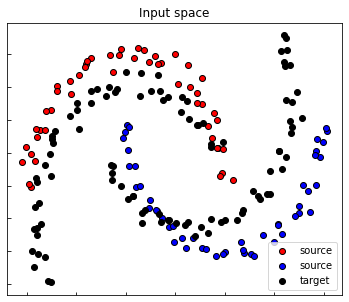

In [7]:
Xs, ys, Xt, yt = make_moons_da()

x_min, y_min = np.min([Xs.min(0), Xt.min(0)], 0)
x_max, y_max = np.max([Xs.max(0), Xt.max(0)], 0)
x_grid, y_grid = np.meshgrid(np.linspace(x_min-0.1, x_max+0.1, 100),
                             np.linspace(y_min-0.1, y_max+0.1, 100))
X_grid = np.stack([x_grid.ravel(), y_grid.ravel()], -1)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title("Input space")
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend(loc="lower right")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')
plt.show()

In [11]:
def get_task(activation="sigmoid", units=1):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(10, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(units, activation=activation))
    return model

In [17]:
mdd = MDD(task=get_task(),
            loss="bce", optimizer=LegacyAdam(0.001, beta_1=0.5),
            copy=True, metrics=["acc"], random_state=0)

In [18]:
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam

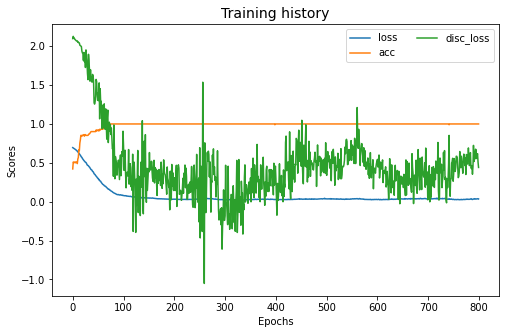

In [19]:
mdd.fit(Xs, ys, Xt, yt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(mdd.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

In [20]:
yt_pred = mdd.predict(Xt)
acc = accuracy_score(yt, yt_pred>0.5)

yp_grid = mdd.predict(X_grid).reshape(100, 100)

X_pca = np.concatenate((mdd.encoder_.predict(Xs),
                        mdd.encoder_.predict(Xt)))
X_pca = PCA(2).fit_transform(X_pca)

4/4 [==============================] - 0s 989us/step


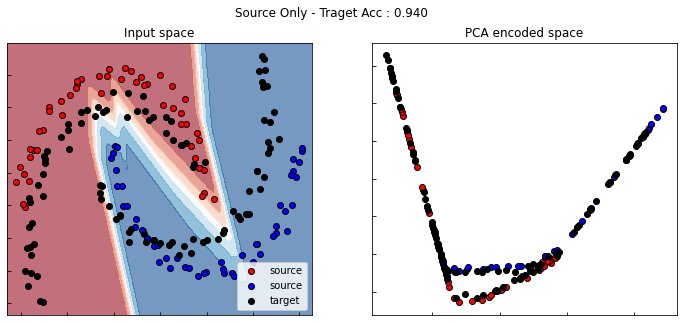

In [22]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

ax2.set_title("PCA encoded space")
ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
            label="source", edgecolors='k', c="red")
ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
            label="source", edgecolors='k', c="blue")
ax2.scatter(X_pca[len(Xs):, 0], X_pca[len(Xs):, 1],
            label="target", edgecolors='k', c="black")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction ='in')
fig.suptitle("Source Only - Traget Acc : %.3f"%acc)
plt.savefig("/root/Adapt/MDD", dpi=300)
plt.show()